**Google Brain - Ventilator Pressure Prediction**

In this notebook, we're going to go through an example machine learning project with the goal of predicting the the airway pressure measured in the respiratory circuit, measured in cmH2O.


**1. Problem Defination**

How well can we predict the the airway pressure measured in the respiratory circuit, given some previous examples of some breath cycles.

**2. Data**

The data is downloaded from the Kaggle Bluebook for google brain competition: https://www.kaggle.com/c/ventilator-pressure-prediction/data

There are 3 main datasets:

1. Train.csv 
2. test.csv
3. sample_submission.csv

**3. Evaluation**

The evaluation metric for this competition is the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. 


**4. Features**

Columns :
id - globally-unique time step identifier across an entire file

breath_id - globally-unique time step for breaths

R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

time_step - the actual time stamp.

u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

u_out - the control input for the exploratory solenoid valve. Either 0 or 1.

pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.



In [ ]:
# Pickimg up modules 
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
#Importing dataset from google drive using pandas
df = pd.read_csv('/content/drive/MyDrive/google brain/train.csv') 
df.head()


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
df.info() #General data insights 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [ ]:
df.isna().sum() # Check for empty cells

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [ ]:
df.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


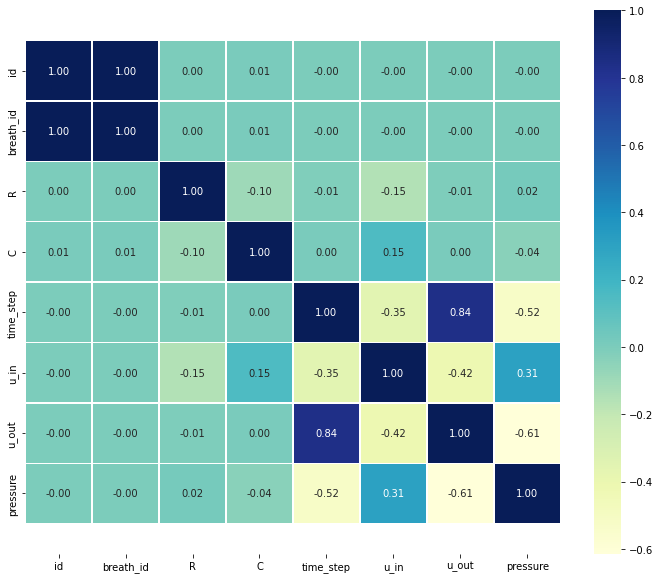

In [ ]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

From this heatmap we conclude that the actual time stamp and exploratory has a negative corrlation with pressure. On the other hand,  the control input for the inspiratory solenoid valve has middle positive corrlation with pressure. 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


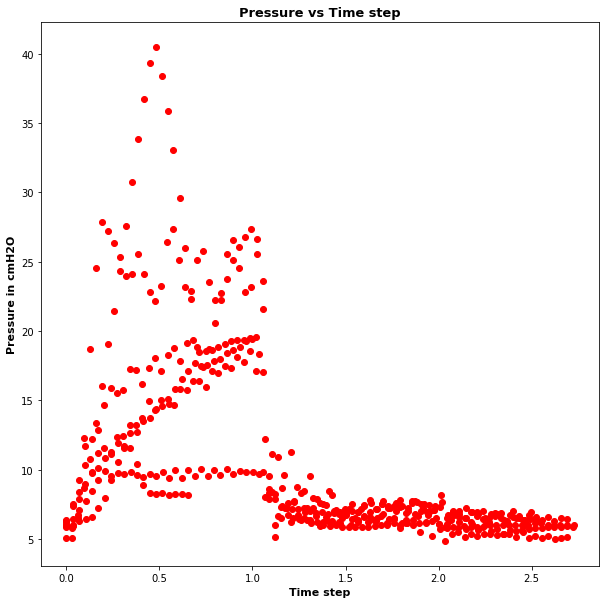

In [ ]:
fig , ax = plt.subplots(figsize=(10,10))
scatter  = ax.scatter(x=df["time_step"][:500],
                      y = df['pressure'][:500],
                      color='red')
ax.set_title('Pressure vs Time step', fontname="Times New Roman", size=13, fontweight="bold")
ax.set_xlabel('Time step', size=11, fontweight="bold")
ax.set_ylabel('Pressure in cmH2O', size=11, fontweight="bold");




This scatter diagram proves the negative correlation between timestamp and pressure.

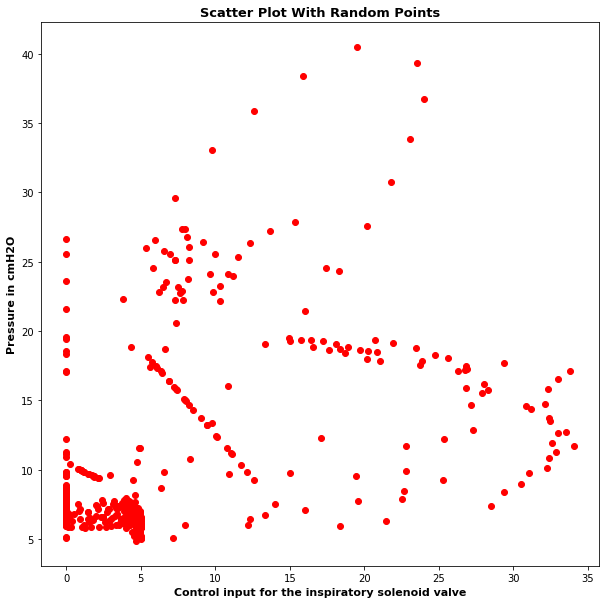

In [ ]:
fig , ax = plt.subplots(figsize=(10,10))
scatter  = ax.scatter(x=df["u_in"][:500],
                      y = df['pressure'][:500],
                      color='red')
ax.set_title('Scatter Plot With Random Points', fontname="Times New Roman", size=13, fontweight="bold")
ax.set_xlabel('Control input for the inspiratory solenoid valve', size=11, fontweight="bold")
ax.set_ylabel('Pressure in cmH2O', size=11, fontweight="bold");


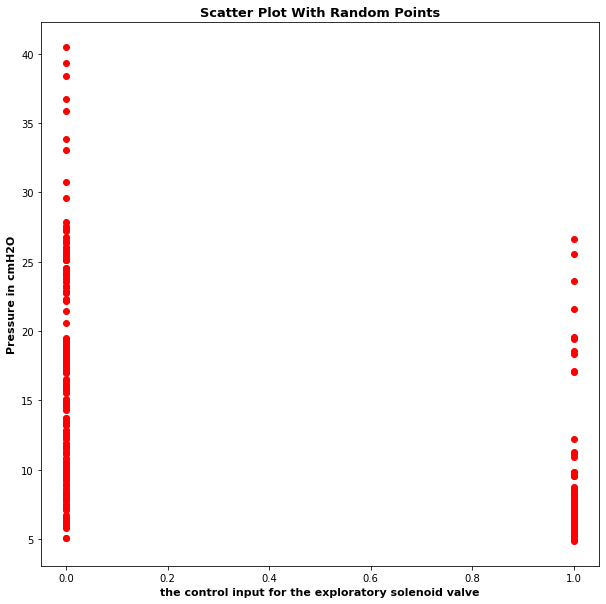

In [ ]:
fig , ax = plt.subplots(figsize=(10,10))
scatter  = ax.scatter(x=df["u_out"][:500],
                      y = df['pressure'][:500],
                      color='red')
ax.set_title('Scatter Plot With Random Points', fontname="Times New Roman", size=13, fontweight="bold")
ax.set_xlabel('the control input for the exploratory solenoid valve', size=11, fontweight="bold")
ax.set_ylabel('Pressure in cmH2O', size=11, fontweight="bold");


This is a negative corroleation.However, the data from control input for the exploratory solenoid valve is not varied (Just 0,1).

In [ ]:
df["u_out"].value_counts()  

1    3745032
0    2290968
Name: u_out, dtype: int64

Just 2 values 

1 = On 

0 = Off

let's vesulaize them using bar chart 

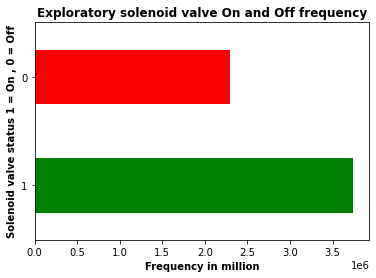

In [ ]:
df["u_out"].value_counts().plot(kind="barh", color=["Green", "red"] );
plt.title ('Exploratory solenoid valve On and Off frequency',fontweight = 'bold')
plt.ylabel("Solenoid valve status 1 = On , 0 = Off" ,fontweight = 'bold')
plt.xlabel("Frequency in million", fontweight = 'bold');

# Modeling

In this notebook we gonna to use Randomforest regressor to predict the pressure values and see if we can improve our predictions by tunning hyperparamters.

In [ ]:
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples = 500000) #Instantation  

                          
# Split data into X and y
# Fit the model
x = df.drop("pressure", axis=1)
y = df['pressure']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2)
len(df), len(x_train), len(x_test)



(6036000, 4828800, 1207200)

In [ ]:
model.fit(x_train,y_train)

RandomForestRegressor(max_samples=500000, n_jobs=-1, random_state=42)

In [ ]:
test_preds = model.predict(x_test)
scores = {"test MAE": mean_absolute_error(y_test, test_preds)}
print(scores)

{'test MAE': 1.837316860092196}


**Make Predictions**

In [ ]:
#Importing dataset from google drive using pandas
df_test = pd.read_csv('/content/drive/MyDrive/google brain/test.csv') 
df_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [ ]:
# The number of each empty fields in each column
df_test.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [ ]:
# type of each data in the columns
df_test.dtypes

id             int64
breath_id      int64
R              int64
C              int64
time_step    float64
u_in         float64
u_out          int64
dtype: object

Now our test data is ready for making predicitions

In [ ]:
# Make our predictions 
final_preds = model.predict(df_test)

In [ ]:
#Importing sample submission from google drive using pandas
submission = pd.read_csv('/content/drive/MyDrive/google brain/sample_submission.csv') 
submission.head()

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
#Add Pressure column with model predictions
submission['pressure'] = final_preds

In [ ]:
submission #Check file again

,id,pressure
0,1,6.228372
1,2,5.851552
2,3,6.993962
3,4,7.876254
4,5,9.676692
...,...,...
4023995,4023996,5.883891
4023996,4023997,5.999890
4023997,4023998,5.850146
4023998,4023999,5.826946


In [ ]:
submission.to_csv("/content/drive/MyDrive/google brain/predicitions2.csv", index=False) #Create a csv file with model predicitions in google drive

Done 